#1. 이해하기

## 1.1 ParallelAgent

### 1.1.1 역할 및 특징

1.  **병렬적 실행**: ParallelAgent의 핵심 기능은 지정된 하위 에이전트 목록을 **동시에(concurrently)** 실행하는 것입니다. 이는 여러 태스크를 동시에 처리하여 전체 작업 시간을 단축할 수 있게 합니다.
2.  **비추론적 오케스트레이션**: 다른 워크플로우 에이전트처럼, ParallelAgent는 LLM(대규모 언어 모델)을 사용하여 어떤 에이전트를 실행할지 추론하는 것이 아니라, 사전에 정의된 대로 모든 하위 에이전트를 병렬로 실행합니다. 따라서 실행 방식 자체는 **결정론적**입니다.
3.  **독립적인 브랜치와 공유된 session state**: ParallelAgent는 각 **하위 에이전트를 실행할 때 `InvocationContext.branch`를 다르게 설정하여 개별적인 컨텍스트 경로를 제공**합니다. 이는 특히 일부 메모리 구현에서 기록을 분리하는 데 유용할 수 있습니다. 하지만, 병렬로 실행되는 모든 하위 에이전트는 **동일한 공유 `session.state`에 접근**할 수 있습니다. 이를 통해 초기 상태를 읽고 결과를 쓸 수 있지만, 충돌을 피하기 위해 결과를 쓸 때는 고유한 키를 사용하는 것이 중요합니다. 실행 중에는 이러한 브랜치 간에 대화 기록이나 상태가 자동으로 공유되지 않습니다.
4.  **결과 수집**: 모든 하위 에이전트의 실행이 완료된 후, ParallelAgent는 일반적으로 각 하위 에이전트의 결과에 접근할 수 있는 방법을 제공합니다. **결과의 순서는 결정론적이지 않을 수 있습니다.**

### 1.1.2 사용 시점

*   독립적인 태스크: **하위 에이전트들이 서로 의존성이 없는 독립적인 태스크를 수행**할 때 ParallelAgent를 사용하기 가장 좋습니다.
*   **속도 중요**: 여러 태스크를 **동시에 실행하여 전체 처리 시간을 줄여야 할 때** 유용합니다. 특히 리소스 집약적인 태스크를 포함하는 시나리오에 적합합니다.
*   **여러 소스에서 데이터 수집**: 여러 소스에서 동시에 데이터를 가져와야 하는 작업.
*   다양한 접근 방식 실행: **동일한 문제에 대해 여러 에이전트가 경쟁적인 접근 방식을 동시에 시도하는 경우**.

## 1.2 Agent에 따른 state 변환

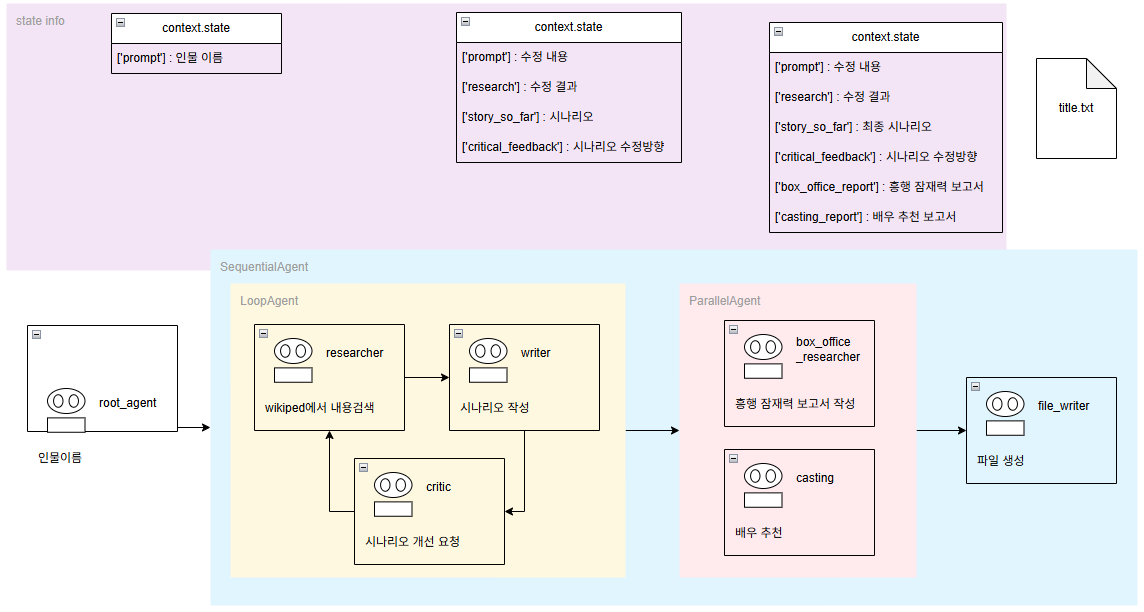

### 1.3 전체 흐름

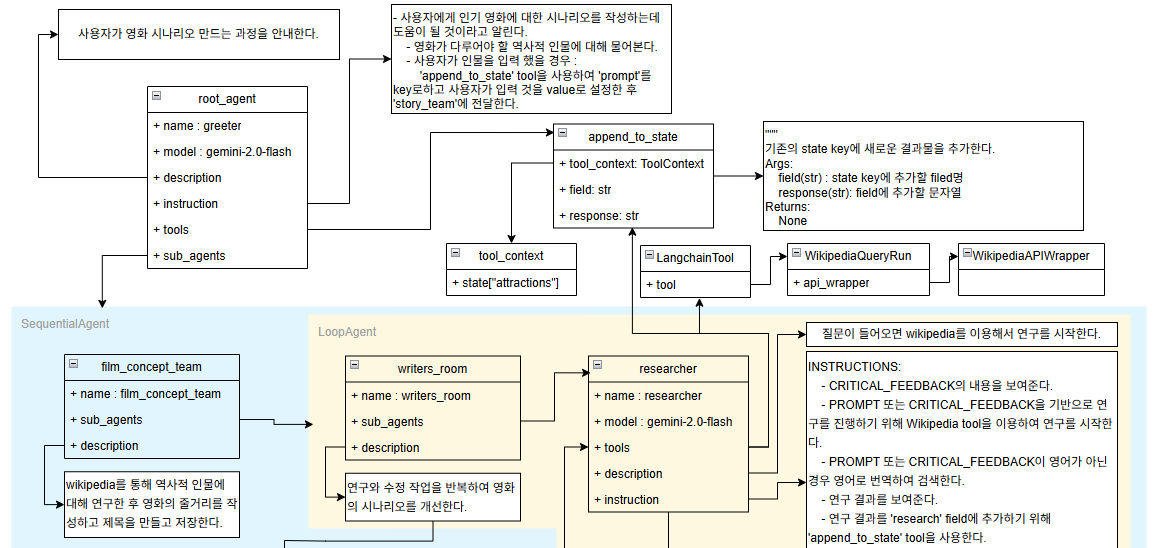

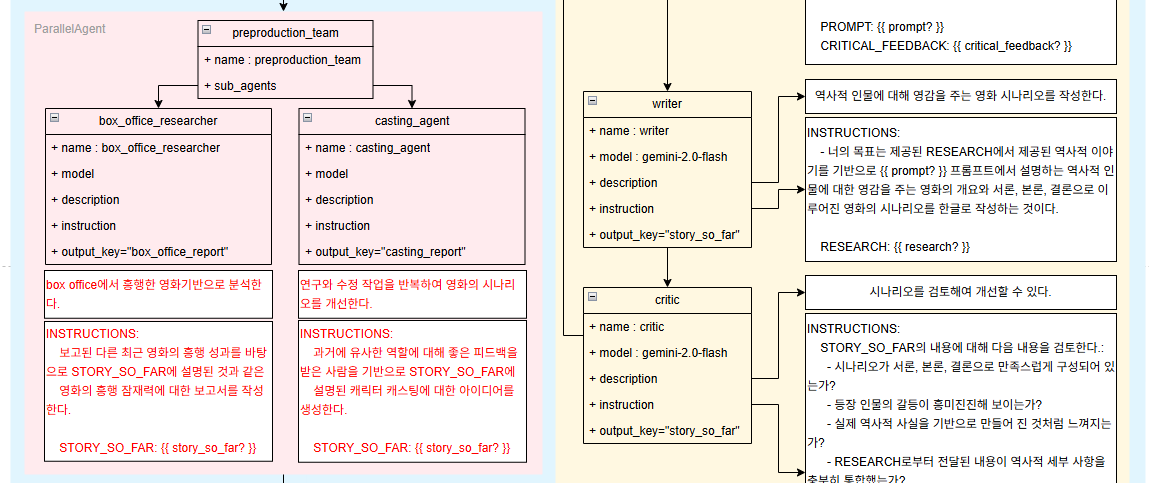

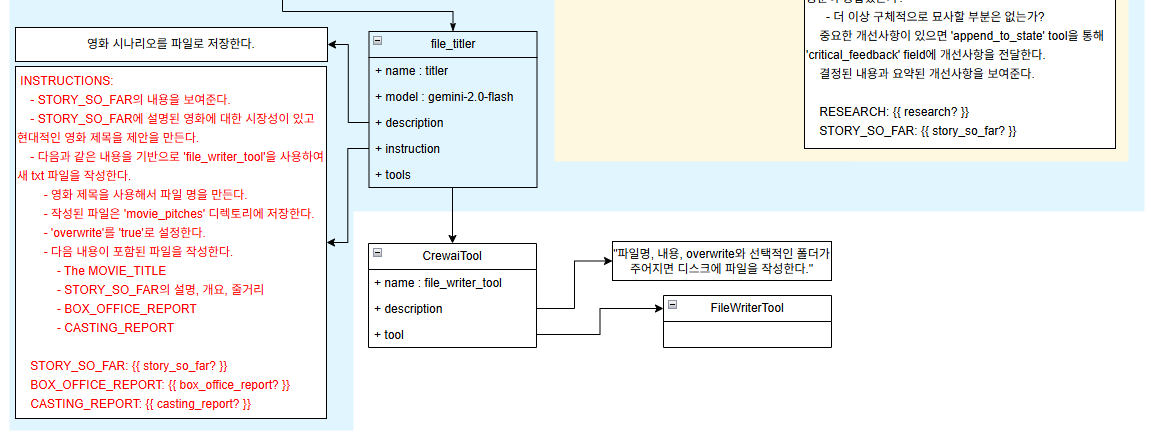

# 2. code



```
pip install google-adk
pip install langchain-community crewai-tools wikipedia
```





```
from google.adk import Agent
from google.adk.agents import SequentialAgent, LoopAgent, ParallelAgent
from google.adk.tools.tool_context import ToolContext
from google.adk.tools.langchain_tool import LangchainTool
from google.adk.tools.crewai_tool import CrewaiTool

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from crewai_tools import FileWriterTool
from google.adk.tools import exit_loop

model_name="gemini-2.0-flash"

def append_to_state(
    tool_context: ToolContext,
    field: str,
    response: str
) -> dict[str, str]:
    """
    기존의 state key에 새로운 결과물을 추가한다..
    Args:
        field (str): state에 추가할 key 이름
        response (str): field에 추가할 문자열
    
    Returns:
        dict[str, str]: {"status": "success"}
    """
    existing_state = tool_context.state.get(field, [])
    tool_context.state[field] = existing_state + [response]
    return {"status": "success"}
    
file_writer = Agent(
    name="file_writer",
    model=model_name,
    description="영화 시나리오를 파일로 저장한다.",
    instruction="""
    INSTRUCTIONS:
    - STORY_SO_FAR의 내용을 보여준다.
    - STORY_SO_FAR에 설명된 영화에 대한 시장성이 있고 현대적인 영화 제목을 제안을 만든다.
    - 다음과 같은 내용을 기반으로 'file_writer_tool'을 사용하여 새 txt 파일을 작성한다.
        - 영화 제목을 사용해서 파일 명을 만든다.
        - 작성된 파일은 'movie_pitches' 디렉토리에 저장한다.
        - 'overwrite'를 'true'로 설정한다.
        - 다음 내용이 포함된 파일을 작성한다.
            - The MOVIE_TITLE
            - STORY_SO_FAR의 설명, 개요, 줄거리
            - BOX_OFFICE_REPORT
            - CASTING_REPORT

    STORY_SO_FAR: {{ story_so_far? }}
    BOX_OFFICE_REPORT: {{ box_office_report? }}
    CASTING_REPORT: {{ casting_report? }}
    """,
    tools = [CrewaiTool(
        name="file_writer_tool",
        description=("파일 이름, 콘텐츠, 디렉터리를 설정한 후 실행하면 디스크에 파일을 만든다."),
        tool=FileWriterTool()
    )]
)

box_office_researcher = Agent(
    name="box_office_researcher",
    model=model_name,
    description="box office에서 흥행한 영화기반으로 분석한다.",
    instruction="""
    INSTRUCTIONS:
    보고된 다른 최근 영화의 흥행 성과를 바탕으로 STORY_SO_FAR에 설명된 것과 같은
    영화의 흥행 잠재력에 대한 보고서를 작성한다.

    STORY_SO_FAR: {{ story_so_far? }}
    """,
    output_key="box_office_report"
)

casting_agent = Agent(
    name="casting_agent",
    model=model_name,
    description="영화를 위한 배우 캐스팅 아이디어를 생성한다.",
    instruction="""
    INSTRUCTIONS:
    과거에 유사한 역할에 대해 좋은 피드백을 받은 사람을 기반으로 STORY_SO_FAR에
    설명된 캐릭터 캐스팅에 대한 아이디어를 생성한다.

    STORY_SO_FAR: {{ story_so_far? }}
    """,
    output_key="casting_report"
)

preproduction_team = ParallelAgent(
    name="preproduction_team",
    sub_agents=[
        box_office_researcher,
        casting_agent
    ]
)

critic = Agent(
    name="critic",
    model=model_name,
    description="시나리오를 검토해여 개선할 수 있다.",
    instruction="""
    INSTRUCTIONS:
    STORY_SO_FAR의 내용에 대해 다음 내용을 검토한다.:
        - 시나리오가 서론, 본론, 결론으로 만족스럽게 구성되어 있는가?
        - 등장 인물의 갈등이 흥미진진해 보이는가?
        - 실제 역사적 사실을 기반으로 만들어 진 것처럼 느껴지는가?
        - RESEARCH로부터 전달된 내용이 역사적 세부 사항을 충분히 통합했는가?
        - 더 이상 구체적으로 묘사할 부분이 없는가?
    STORY_SO_FAR이 이러한 질문을 잘 처리했다면 'exit_loop' 도구를 사용하여 쓰기 루프를 종료한다.
    중요한 개선사항이 있으면 'append_to_state' tool을 통해 'critical_feedback' field에 개선사항을 전달한다.
    결정된 내용과 요약된 개선사항을 보여준다.
    

    RESEARCH: {{ research? }}

    STORY_SO_FAR: {{ story_so_far? }}
    """,
    tools=[append_to_state, exit_loop],
)
writer = Agent(
    name="writer",
    model=model_name,
    description="역사적 인물에 대해 영감을 주는 영화 시나리오를 작성한다.",
    instruction="""
    INSTRUCTIONS:
    - 너의 목표는 제공된 RESEARCH에서 제공된 역사적 이야기를 기반으로
    {{ prompt? }} 프롬프트에서 설명하는 역사적 인물에 대한 영감을 주는
    영화의 개요와 서론, 본론, 결론으로 이루어진 영화의 시나리오를 한글로 작성하는 것이다.

    RESEARCH: {{ research? }}
    """,
    output_key="story_so_far",
)

researcher = Agent(
    name="researcher",
    model=model_name,
    description="질문이 들어오면 wikipedia를 이용해서 연구를 시작한다.",
    instruction="""
    INSTRUCTIONS:
    - CRITICAL_FEEDBACK의 내용을 보여준다.
    - PROMPT 또는 CRITICAL_FEEDBACK을 기반으로 연구를 진행하기 위해 Wikipedia tool을 이용하여 연구를 시작한다.
    - PROMPT 또는 CRITICAL_FEEDBACK이 영어가 아닌 경우 영어로 번역하여 검색한다.
    - 연구 결과를 보여준다.
    - 연구 결과를 'research' field에 추가하기 위해 'append_to_state' tool을 사용한다.

    PROMPT: {{ prompt? }}
    CRITICAL_FEEDBACK: {{ critical_feedback? }}
    """,
    tools = [
        LangchainTool(
            tool=WikipediaQueryRun(
                api_wrapper=WikipediaAPIWrapper()
            )
        ),
        append_to_state
    ]
)

writers_room = LoopAgent(
    name="writers_room",
    description="연구와 수정 작업을 반복하여 영화의 시나리오를 개선한다.",
    sub_agents=[
        researcher,
        writer,
        critic
    ],
    max_iterations=5,
)

film_concept_team = SequentialAgent(
    name="film_concept_team",
    description="영화의 시나리오를 작성하여 텍스트 파일로 저장한다.",
    sub_agents=[
        writers_room,
        preproduction_team,
        # titler,
        file_writer
    ],
)

root_agent = Agent(
    name="greeter",
    model=model_name,
    description="사용자가 영화 시나리오 만드는 과정을 안내한다.",
    instruction="""
    - 사용자에게 인기 영화에 대한 시나리오를 작성하는데 도움이 될 것이라고 알린다.
    - 영화가 다루어야 할 역사적 인물에 대해 물어본다.
    - 사용자가 인물을 입력 했을 경우:
        'append_to_state' tool을 사용하여 'prompt'를 key로하고
        사용자가 입력 것을 value로 설정한 후 'film_concept_team'에 전달한다.
    """,
    tools=[append_to_state],
    sub_agents=[film_concept_team]
)
```

